# 主成分分析

主成分分析は，回帰とともによく用いられる統計手法です。主成分分析は，ビッグデータを要約することができます。気象学では経験的直交函数（Empirical Orthogonal Functions, EOF），機械学習では次元削減手法として用いられる特異値分解，様々な分野の数値解析に用いられる固有値解析としても知られています。Numpyを使って手を動かしながらどのような手法か学んでいきましょう。

## 特異値解析

100個の観測が2組得られたとします。二つの組には何らかの関係があります。ばらつきの大きい方向を特異値解析で求めましょう。

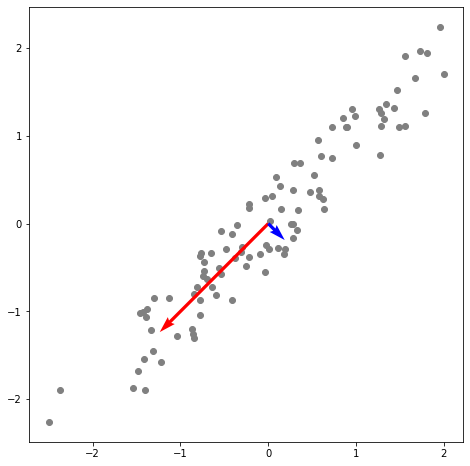

In [2]:
import numpy as np
import matplotlib.pyplot as plt


m = 100
rng = np.random.default_rng(0)
x = rng.standard_normal(m)
x = (x - x.mean()) / x.std()
y = x + rng.random(m)
y = (y - y.mean()) / y.std()
 
X = np.array([x, y]).transpose()
m, n = X.shape
U, s, Vt = np.linalg.svd(X)
V = Vt.transpose()
 
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, color='gray')
c = ["r", "b"]
for i in range(n):
   ax.quiver(s[i]*V[0, i], s[i]*V[1, i],
             units='xy', angles='xy', scale=8, color=c[i])
ax.set_aspect('equal')
plt.show()

乱数で`x`を生成し，それを少し乱した`y`を作ります。標準化した後100×2の配列`X`にまとめます。これを`np.linalg.svd()`で特異値分解をしてばらつきの大きい方向（固有ベクトル）を求めています。●はデータ，→は右特異ベクトルで特異値に比例させています。赤，青はそれぞれ1番目，2番目に分散が大きい方向を表します。

## 特異値解析と固有値解析との関係

ここで，特異値解析と固有値解析との関係についておさらいをしておきます。ここではデータは実数とします。特異値分解は，$m$個のデータ$n$組を並べた$m\times n$行列$\mathbf{X}$を

$$
\begin{equation}
\mathbf{X} = \mathbf{USV}^T\label{svd}
\end{equation}
$$ (svd)

のように分解するものです。$\mathbf{U}$は$m\times m$行列，$\mathbf{S}$は$m\times n$行列，$\mathbf{V}$は$n\times n$行列です。$\mathbf{U}$は左特異ベクトル，$\mathbf{V}$は右特異ベクトルと呼ばれています。特異値は$\mathbf{S}$の対角成分として最大$m$と$n$の小さい方の個数（$p = \min(m, n)$）が得られます。$\mathbf{U}$と$\mathbf{V}$はともに直交行列で$\mathbf{U}^T\mathbf{U}=\mathbf{UU}^T=\mathbf{I}$，$\mathbf{V}^T\mathbf{V}=\mathbf{VV}^T=\mathbf{I}$が成り立ちます。

行列Xの要素が偏差であるとします。年々変動の問題を考えている場合は，偏差は各年の値から平年値を引いた値です。$j$番目の偏差は行列$\mathbf{X}$の$j$番目の列ベクトル$\mathbf{x}_j$で表されます。$j$番目の偏差同士の内積$\mathbf{x}_j^T\mathbf{x}_j$は分散，異なる列$i≠j$の内積$\mathbf{x}_i^T\mathbf{x}_j$は共分散を表します。まとめて共分散行列$\mathbf{C}=\mathbf{X}^T\mathbf{X}$と書き表すことができます。共分散行列の対角成分は分散，非対角成分は共分散を表します。式{eq}`svd`の両辺の転置をとり右から掛けます。$\mathbf{U}$が直交行列であることを利用すると
\begin{equation}
\mathbf{C} = \mathbf{X}^T\mathbf{X} = \mathbf{VS}^2\mathbf{V}^T\label{covar}
\end{equation}
が得られます。右から直交行列$\mathbf{V}$を掛けると
\begin{equation}
\mathbf{CV} = \mathbf{VS}^2\label{eigen}
\end{equation}
となり，固有値問題$\mathbf{Cv} = \lambda\mathbf{v}$を行列で表したものが得られました。つまり，$\lambda = s_{ii}^2$すなわち特異値の二乗が固有値です。

図4の赤矢印が示すように，1番目の特異ベクトルは分散が最大の方向，2番目の矢印は1番目のベクトルと直交するのもののうち，分散が最大になる方向を表します。ただし，図4の例は2次元なので，2番目の方向は青矢印の方向に自動的に決まってしまいます。$\mathbf{V}$の列は固有値（特異値）に対応する固有ベクトル$\mathbf{v}$を表しています。統計学では，データに回帰させた$\mathbf{Xv}$を主成分と呼んでいます。年々変動の例では空間パターンを表し，気象学では$j$番目の主成分をEOF第$j$モードと呼んでいます。固有値の和に対する各モードの固有値の比
\begin{equation}
\frac{s_j^2}{\sum_{j=1}^p s_j^2}\label{contribution}
\end{equation}
を寄与率といいます。1番目から$j$番目までの寄与率の和（累積寄与率）が例えば80%を超えているとすると，第$j$モードまででデータの特性を8割説明することができることになります。$j$は$p = \min(m, n)$よりも小さいので，少ないモードでデータを表す次元縮約が実現できることになります。

## 年々変動の解析

月平均の海面気圧データに主成分分析を適用してみましょう。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


ds = xr.open_dataset("slp.mon.mean.nc")

1月を取り出して，平均と標準偏差を計算します。

In [2]:
slp = ds.slp[0::12]
slp_clim = slp.mean(axis=0)
slp_stddev = slp.std(axis=0)

描画のための関数を定義しておきます。
解析結果が`ndarray`になるので，経度と緯度も引数として与えます。

In [3]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point


def plot_nps(lon, lat, data):
    datac, lonc = add_cyclic_point(data, lon)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo(135))
    p = ax.contourf(lonc, lat, datac, transform=ccrs.PlateCarree())
    ax.set_extent([0, 359.999, 20, 90], ccrs.PlateCarree())
    fig.colorbar(p)
    ax.coastlines()

気候値はアイスランドとアリューシャンに低気圧，シベリアに高気圧のある特徴的な気圧配置です。

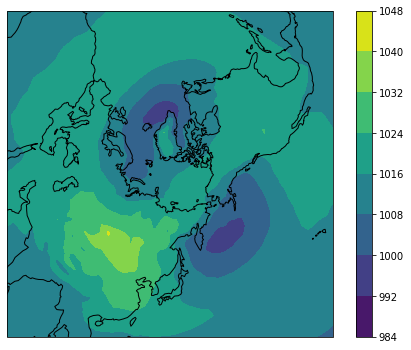

In [4]:
plot_nps(ds.lon, ds.lat, slp_clim)

標準偏差を見ると，年々変動はアイスランドとアリューシャンで大きいことが分かります。

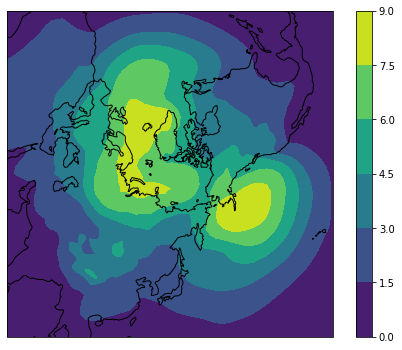

In [5]:
plot_nps(ds.lon, ds.lat, slp_stddev)

### 特異値分解

緯度円の長さは極に近づくほど短くなりますので，1点1点が代表する面積は緯度$\phi$が高くなるにつれて縮小します。
そのためデータには緯度の重みを掛ける必要があります。
緯度円の長さは緯度の余弦に比例するので，これを重みとして用います。
共分散行列では海面気圧気圧偏差の2乗になるので，偏差行列には平方根$\sqrt{\cos\phi}$が重みになります。
緯度がガウス緯度の場合は，ガウス重みを用いることができます。

In [7]:
wgt = np.sqrt(np.abs(np.cos(np.deg2rad(ds.lat))))

海面気圧偏差をその標準偏差で規格化します。
気候値`slp_clim`は2次元ですが，時間の次元があり3次元の`slp`から`for`ループを使わずに引くことができています。
これらの変数がnumpyの`ndarray`でも[ブロードキャスト](https://numpy.org/doc/stable/user/basics.broadcasting.html)により2次元配列が繰り返して用いられます。

これに対し，`dslp * wgt`において`wgt`と`dslp`とでは最も右の長さが異なります。
そのためnumpyではエラーになりますが，xarrayでは`wgt`のラベルが`lat`であることを利用してその他の次元に対してブロードキャストが行われます。
もし`ndarray`で`dslp`と`wgt`の最も右の長さがたまたま一致している場合はエラーにならないので，誤った計算が行われることになります。
xarrayのラベルはバグを防ぐ効果があります。

`where`メソッドで北緯20度より極よりのデータを選びます。
既定では大きさはそのままで非数`np.NaN`が入るので，`drop=True`で落とします。
空間を1次元化したあと転置して各年の偏差を列ベクトルとする行列にします。

In [8]:
dslp = (slp - slp_clim) / slp_stddev
X = dslp * wgt
X = (X.where(ds.lat>20, drop=True)).data.reshape(X.shape[0],-1).transpose()

In [9]:
U, s, V = np.linalg.svd(X)

寄与率を図示しましょう。

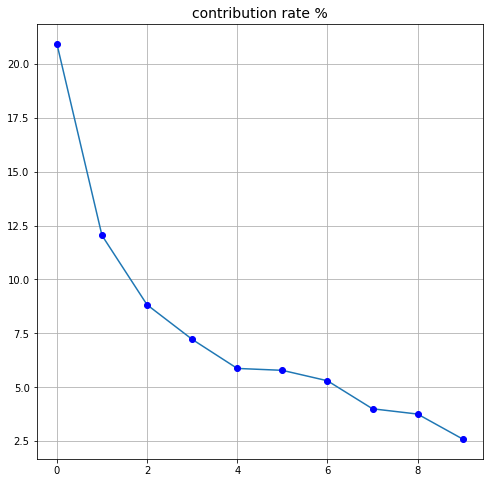

In [10]:
contrib = (s * s) / (s @ s) * 100

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(contrib[0:10])
ax.plot(contrib[0:10],'bo')
ax.set_title("contribution rate %", fontsize=14)
ax.grid()
plt.show()

### 回帰

右特異ベクトルは各年の重みを表す主成分得点です。偏差に対して回帰を取ると空間パターンが得られます。
特異ベクトルは大きい順に入っているので，0番目が第1モードになります。第1モードは北極振動，第2モードはアリューシャン・アイスランド・シーソー，第3モードは太平洋・北米パターンに類似しています。

In [11]:
D = (dslp.data.transpose() @ V.transpose()).transpose()

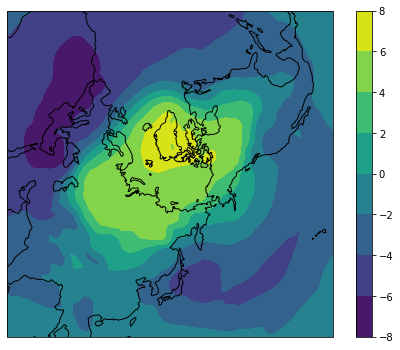

In [12]:
plot_nps(ds.lon, ds.lat, D[0])

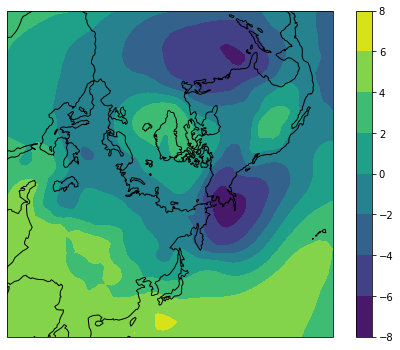

In [13]:
plot_nps(ds.lon, ds.lat, D[1])

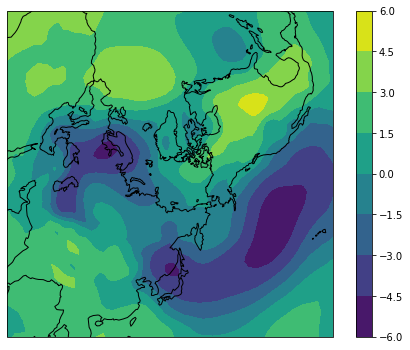

In [14]:
plot_nps(ds.lon, ds.lat, D[2])

### 固有値分解

共分散行列の固有値分解でも同じになるか確認します。

In [15]:
cov = (X.transpose() @ X) / (X.shape[1] - 1)
W, V_eig = np.linalg.eig(cov)
D_eig = (dslp.data.transpose() @ V_eig).transpose()

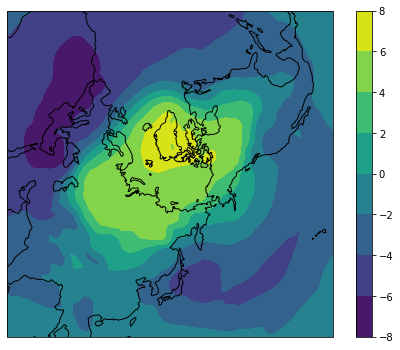

In [16]:
plot_nps(ds.lon, ds.lat, D_eig[0])